### Dataset : https://www.kaggle.com/c/fake-news/data#

In [1]:
#Creating an LSTM model for fake news detection using kaggle dataset
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
#Dropping the na values,Since we are using the titles.
train.isna().sum()[1]/len(train)
#Only 2% of the Data is 

0.026826923076923078

In [6]:
train = train.drop(['author','id','text'],axis=1)

In [7]:
train.isna().sum()/len(train)*100

title    2.682692
label    0.000000
dtype: float64

In [8]:
train = train.dropna()

In [9]:
train.reset_index(inplace = True)

In [10]:
X,y=train['title'],train['label']

In [11]:
#Use preprocessing to clean the data,get rid of stopwords and special characters
import nltk
import re
from nltk.corpus import stopwords

In [12]:
X_post = X.copy()

In [13]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
corpus = []
for i in range(0, len(X.copy())):
    review = re.sub('[^a-zA-Z]', ' ',X_post[i])
    review = review.lower()
    review = review.split()
    review = [porter.stem(word) for word in review if not word in stopwords.words('english')]
    #review = " ".join(review)
    corpus.append(review)

In [14]:
corpus[1:5]

[['flynn', 'hillari', 'clinton', 'big', 'woman', 'campu', 'breitbart'],
 ['truth', 'might', 'get', 'fire'],
 ['civilian', 'kill', 'singl', 'us', 'airstrik', 'identifi'],
 ['iranian',
  'woman',
  'jail',
  'fiction',
  'unpublish',
  'stori',
  'woman',
  'stone',
  'death',
  'adulteri']]

In [15]:
#To form the correct padded_sentences for embedding matrix.
t=0 
for i in range(0,len(corpus)):
    if len(corpus[i])>=t:
        t = len(corpus[i])
print(t)

47


In [16]:
#Another way for correctly identifying the padding for embedding matrix.
q=[len(corpus[i]) for i in range(0,len(corpus))]
max(q)

47

In [17]:
messages =[]
for i in range(0,len(corpus)):
    item = corpus[i]
    item = " ".join(item)
    messages.append(item)

In [18]:
messages[1:5]

['flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri']

In [19]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [20]:
voc_size = 10000

In [21]:
#Using One Hot encodding to convert the words from text format,could also use tokenizer
onehot_repr=[one_hot(words,voc_size)for words in messages] 
onehot_repr[1:10]

[[1262, 3901, 2523, 6531, 2556, 4256, 6267],
 [1539, 8871, 3597, 9540],
 [8857, 5476, 3189, 385, 7027, 9430],
 [8518, 2556, 16, 4892, 5610, 4375, 2556, 6550, 2565, 9499],
 [5008,
  1840,
  8524,
  3978,
  5444,
  8079,
  5182,
  6764,
  9161,
  8140,
  7073,
  2333,
  2704,
  6952,
  6267],
 [9701, 9701, 3947, 6870, 5232, 6751, 2141, 239, 837, 2617, 8059, 4308],
 [1247, 9659, 5802, 9825, 8802, 7325, 3162, 8977, 707, 717, 6852],
 [7544, 1507, 5014, 5803, 8079, 5846, 3002, 4449, 1496, 9417, 707, 717, 6852],
 [9253, 6082, 4073, 5644, 6443, 7688, 8079, 2054, 707, 717, 6852]]

In [22]:
#Choose a sentence length higher than 47 for padding 
sent_length=50
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
print(embedded_docs)

[[1444 2990 2938 ...    0    0    0]
 [1262 3901 2523 ...    0    0    0]
 [1539 8871 3597 ...    0    0    0]
 ...
 [5167 8903 2520 ...    0    0    0]
 [1303 6443 3047 ...    0    0    0]
 [5015 4883 4800 ...    0    0    0]]


In [23]:
#Creating an initial model 
embedding_vector_features=20
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               48400     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 248501 (970.71 KB)
Trainable params: 248501 (970.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [24]:
X_fn=np.array(embedded_docs)
y_fn=np.array(y)

In [25]:
#Train and validation split for evaluating the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_fn, y_fn, test_size=0.3, random_state=42)

In [26]:
#Training the model 
model.fit(X_train,y_train,validation_data=(X_fn,y_fn),epochs=10,batch_size=100)

Epoch 1/10
142/142 [==============================] - 8s 49ms/step - loss: 0.6867 - accuracy: 0.5206 - val_loss: 0.4188 - val_accuracy: 0.8666
Epoch 2/10
142/142 [==============================] - 7s 47ms/step - loss: 0.6109 - accuracy: 0.6367 - val_loss: 0.6930 - val_accuracy: 0.5133
Epoch 3/10
142/142 [==============================] - 7s 46ms/step - loss: 0.6930 - accuracy: 0.5095 - val_loss: 0.6927 - val_accuracy: 0.5145
Epoch 4/10
142/142 [==============================] - 7s 47ms/step - loss: 0.6779 - accuracy: 0.5505 - val_loss: 0.6116 - val_accuracy: 0.6380
Epoch 5/10
142/142 [==============================] - 7s 47ms/step - loss: 0.5313 - accuracy: 0.7281 - val_loss: 0.3533 - val_accuracy: 0.8837
Epoch 6/10
142/142 [==============================] - 7s 48ms/step - loss: 0.2484 - accuracy: 0.9143 - val_loss: 0.2054 - val_accuracy: 0.9375
Epoch 7/10
142/142 [==============================] - 7s 47ms/step - loss: 0.1483 - accuracy: 0.9487 - val_loss: 0.1495 - val_accuracy: 0.9525

In [28]:
from sklearn.metrics import accuracy_score

In [30]:
y_pred = (model.predict(X_test)>0.5).astype("int32")

190/190 [==============================] - 1s 5ms/step


In [31]:
accuracy_score(y_test,y_pred0


0.9114111641692738

#### From the accuracy score,we have a problem of overfitting in the model.

In [32]:
#Clearly we have a case of overfitting, we can use various ways such as L1,L2 regularization or dropout method.
from tensorflow.keras.layers import Dropout

In [55]:
embedding_vector_features=20
model_drop=Sequential()
model_drop.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_drop.add(Dropout(0.4))
model_drop.add(LSTM(100))
model_drop.add(Dropout(0.4))
model_drop.add(Dense(1,activation='sigmoid'))
model_drop.add(Dropout(0.1))
model_drop.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_drop.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 20)            200000    
                                                                 
 dropout_21 (Dropout)        (None, 50, 20)            0         
                                                                 
 lstm_12 (LSTM)              (None, 100)               48400     
                                                                 
 dropout_22 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
 dropout_23 (Dropout)        (None, 1)                 0         
                                                                 
Total params: 248501 (970.71 KB)
Trainable params: 24

In [57]:
model_drop.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
222/222 [==============================] - 6s 28ms/step - loss: 1.4000 - accuracy: 0.5050 - val_loss: 0.6986 - val_accuracy: 0.5103
Epoch 2/10
222/222 [==============================] - 6s 27ms/step - loss: 1.2576 - accuracy: 0.6261 - val_loss: 0.6999 - val_accuracy: 0.4971
Epoch 3/10
222/222 [==============================] - 6s 27ms/step - loss: 1.0475 - accuracy: 0.8290 - val_loss: 0.4255 - val_accuracy: 0.8582
Epoch 4/10
222/222 [==============================] - 6s 27ms/step - loss: 1.1225 - accuracy: 0.8479 - val_loss: 0.4071 - val_accuracy: 0.8739
Epoch 5/10
222/222 [==============================] - 6s 27ms/step - loss: 1.0179 - accuracy: 0.8696 - val_loss: 0.4675 - val_accuracy: 0.8833
Epoch 6/10
222/222 [==============================] - 6s 27ms/step - loss: 1.0731 - accuracy: 0.8754 - val_loss: 0.2596 - val_accuracy: 0.9071
Epoch 7/10
222/222 [==============================] - 6s 26ms/step - loss: 0.9861 - accuracy: 0.8729 - val_loss: 0.2936 - val_accuracy: 0.8953

### Above model produces much better results 


In [58]:
y_pred_drop = (model_drop.predict(X_test) > 0.5).astype("int32")

190/190 [==============================] - 1s 6ms/step


In [59]:
from sklearn.metrics import confusion_matrix


In [60]:
cf_matrix= confusion_matrix(y_test,y_pred_drop)
cf_matrix

array([[2779,  320],
       [ 151, 2823]])

In [63]:
from sklearn.metrics import accuracy_score

In [64]:
accuracy_score(y_pred_drop,y_test)

0.9224436028322082

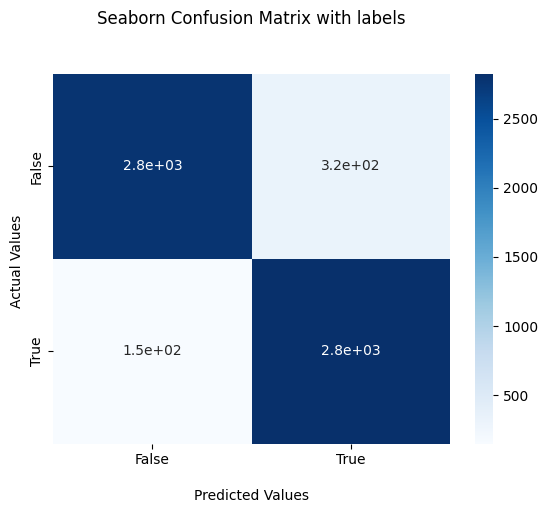

In [65]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [66]:
from sklearn.metrics import classification_report


In [67]:
classification_report(y_test,y_pred_drop)

'              precision    recall  f1-score   support\n\n           0       0.95      0.90      0.92      3099\n           1       0.90      0.95      0.92      2974\n\n    accuracy                           0.92      6073\n   macro avg       0.92      0.92      0.92      6073\nweighted avg       0.92      0.92      0.92      6073\n'